## Setup

### Import Libraries, Set up device, Set up seeds

In [1]:
# Imports
import gpytorch
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from tqdm import trange
import pandas as pd
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, StudentTLikelihood
from gpytorch.mlls import VariationalELBO

# check for MPS and CUDA device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found, setting as device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found, setting as device.")
else:
    device = torch.device("cpu")
    print("Neither MPS nor CUDA device found. Using default device (CPU).")


# set the seed for all random use
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seeds(22)

# Initial setup
training_iterations = 20
num_initial_points = 3
num_new_samples_per_iteration = 1  # Change this to your desired number of new samples per iteration
total_samples = 100
acqFunc = "UCB"  # Change this to your desired acquisition function, UCB or EI

CUDA device found, setting as device.


### Sin wave objective function with noise and outliers added

In [2]:
# Create the training data
set_seeds(0)
X = np.linspace(0.0, np.pi * 2, total_samples)[:, None]
Y = np.sin(X)
cauchy_noise = np.random.standard_cauchy(Y.shape) * 0.06
Yc = Y + cauchy_noise
Yc = Yc/Yc.max()
X = X/X.max()
# Slightly noisy data
Yc[75:80] += 1

### Cauchy distribution with noise

In [3]:
# Step 1: Define the mixture of Cauchy distributions
def mixture_cauchy_function(x, x0s=[0], gammas=[1], weights=[1]):
    assert len(x0s) == len(gammas) == len(weights), "Length of parameters must match"
    mixture = np.zeros_like(x)
    for x0, gamma, weight in zip(x0s, gammas, weights):
        mixture += weight * (1 / (np.pi * gamma * (1 + ((x - x0) / gamma) ** 2)))
    return mixture / np.sum(weights)

# Step 2: Sample 200 points from the function
np.random.seed(0)  # For reproducibility
X = np.linspace(-10, 10, total_samples)
x0s = [0, 0, 0]  # Location parameters
gammas = [1, 3, 5]  # Scale parameters for heavier tails
weights = [1, 1, 1]  # Equal weights for simplicity
Y = mixture_cauchy_function(X, x0s, gammas, weights)

# Step 3: Add noise to the sampled points
cauchy_noise = np.random.standard_cauchy(Y.shape) * 0.01
Yc = Y + cauchy_noise
Yc = Yc/Yc.max()
X = X/X.max()

# Slightly noisy data
Yc[40:45] += 0

### Student-T Process Model

In [4]:
class ApproximateGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-1))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=False
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Exact Gaussian Process Model

In [5]:
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        # build the model using the ExactGP model from gpytorch
        super(ExactGP, self).__init__(x_train, y_train, likelihood)

        # use a constant mean, this value can be learned from the dataset
        self.mean_module = gpytorch.means.ConstantMean()

        # automatically determine the number of dimensions for the ARD kernel
        num_dimensions = x_train.dim()

        # use a scaled Matern kernel, the ScaleKernel allows the kernel to learn a scale factor for the dataset
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=num_dimensions))
            
        # set the number of outputs 
        self.num_outputs = 1

    def forward(self, x):
        # forward pass of the model

        # compute the mean and covariance of the model 
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # return the MultivariateNormal distribution of the mean and covariance 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    

### Variational Gaussian Process Model

In [6]:
class VariationalGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(VariationalGP, self).__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.size(0)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Acquisition Functions

In [7]:
# Upper Confidence Bound
def UCB(mean, std, beta):
    return mean + beta * std


# Expected Improvement
def EI(mean, std, best_observed):
    z = (mean - best_observed) / std
    return (mean - best_observed) * torch.distributions.Normal(0, 1).cdf(z) + std * torch.distributions.Normal(0, 1).log_prob(z)

### Randomly initialize training data with 10 points


In [8]:
train_x = torch.from_numpy(X.ravel()).to(dtype=torch.float64)
train_y = torch.from_numpy(Yc.ravel()).to(dtype=torch.float64)

indicesSTP = torch.randperm(total_samples)[:num_initial_points]
indicesEGP = indicesSTP
indicesVGP = indicesSTP

train_xSTP = train_x[indicesSTP]
train_ySTP = train_y[indicesSTP]
train_xEGP = train_xSTP
train_yEGP = train_ySTP
train_xVGP = train_xSTP
train_yVGP = train_ySTP
initialPoints = train_xSTP
initialPointsy = train_ySTP

## Bayesian Optimization Loops

### Student-T Process Optimization

In [9]:
for _ in trange(training_iterations):
    #def train_and_test_approximate_gp(objective_function_cls):
    model = ApproximateGPModel(train_xSTP).to(dtype=torch.float64)
    #likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood = gpytorch.likelihoods.StudentTLikelihood()
    objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_ySTP.numel())
    # replace with gpytorch mll
    optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)


    # Train
    model.train()
    #put it into training mode
    likelihood.train()

    for _ in range(50):
        output = model(train_xSTP)
        loss = -objective_function(output, train_ySTP)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    # Test
    model.eval()
    likelihood.eval()

    # works wtih the variational distribution
    with gpytorch.settings.num_likelihood_samples(512):
        observed_pred = likelihood(model(train_x))

    samples = observed_pred.sample()


    # use as inputs to UCB 
    meanSTP = samples.mean(dim=0)
    stdSTP = samples.std(dim=0)
    
    if acqFunc == "UCB":
        # Select new points using UCB
        ucb_values = UCB(meanSTP, stdSTP, 1.96)
        ucb_values[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, ucb_values.argmax().unsqueeze(0)])
    elif acqFunc == "EI":
        # Select new points using EI
        ei_values = EI(meanSTP, stdSTP, train_ySTP.max())
        ei_values[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, ei_values.argmax().unsqueeze(0)])
    else:
        print("Please change the acquisition function to UCB or EI in the setup")
        raise ValueError("Invalid acquisition function specified")


    # Convert new_indices to a tensor
    # Add the new points to the training data
    train_xSTP = train_x[indicesSTP]
    train_ySTP = train_y[indicesSTP]

100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


### Exact Gaussian Process Optimization

In [10]:
for i in trange(training_iterations):
    # standardize the initial inputs and outputs before
    # torch_std = TorchStandardScaler()
    # train_xGP = torch_std.fit_transform(train_xGP)
    # y_scaler = TorchStandardScaler()
    # train_yGP = y_scaler.fit_transform(train_yGP).flatten()

    bestY_EGP = train_yEGP.max().item()

    # optimize the model
    # use a half normal prior for the noise to find a Gaussian likelihood
    likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))

    # using the found likelihood, create a GP model
    gp = ExactGP(train_xEGP, train_yEGP, likelihood)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

    # fit the model by maximizing the marginal log likelihood
    gp.train()
    likelihood.train()
    fit_gpytorch_mll(mll)

    gp.eval()
    likelihood.eval()

    # predict from candidate pool
    with torch.no_grad():
        pred = gp(train_x) # predict values for all candidates

    meanEGP = pred.mean
    stdEGP = pred.stddev

    # pass the predictions through an acquisition function to find the next best point to sample
    acqVal = UCB(meanEGP, stdEGP, 1.96)
    acqVal[indicesEGP] = -float('inf')  # Don't select already sampled points
    indicesEGP = torch.cat([indicesEGP, acqVal.argmax().unsqueeze(0)]) # add best value to index

    # add the new point to the training data
    train_xEGP = train_x[indicesEGP]
    train_yEGP = train_y[indicesEGP]

model.eval()
likelihood.eval()

100%|██████████| 20/20 [00:01<00:00, 18.27it/s]


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (noise_prior): HalfNormalPrior()
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

### Variational Gaussian Process Optimization

In [11]:
for _ in trange(training_iterations):
    # standardize the initial inputs and outputs before
    # torch_std = TorchStandardScaler()
    # train_xSTP = torch_std.fit_transform(train_xSTP)
    # y_scaler = TorchStandardScaler()
    # train_ySTP = y_scaler.fit_transform(train_ySTP).flatten()  # Ensure y is 1-dimensional

    #def train_and_test_approximate_gp(objective_function_cls):
    model = VariationalGP(train_xVGP).to(dtype=torch.float64)

    likelihood = GaussianLikelihood()
    objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_yVGP.numel())
    # replace with gpytorch mll
    optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

    # Train
    model.train()
    #put it into training mode
    likelihood.train()

    for _ in range(50):
        output = model(train_xVGP)
        loss = -objective_function(output, train_yVGP)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # Test
    model.eval()
    likelihood.eval()

    # works wtih the variational distribution
    with gpytorch.settings.num_likelihood_samples(512):
        observed_pred = likelihood(model(train_x))

    samples = observed_pred.sample(torch.Size((100,)))

    # get the mean and standard deviation of the samples
    meanVGP = samples.mean(dim=0)
    stdVGP = samples.std(dim=0)

    # Select new points using UCB
    ucb_values = UCB(meanVGP, stdVGP, 1.96)
    ucb_values[indicesVGP] = -float('inf')
    indicesVGP = torch.cat([indicesVGP, ucb_values.argmax().unsqueeze(0)])


    # Convert new_indices to a tensor
    # Add the new points to the training data
    train_xVGP = train_x[indicesVGP]
    train_yVGP = train_y[indicesVGP]

model.eval()
likelihood.eval()
    

100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

## Visualization

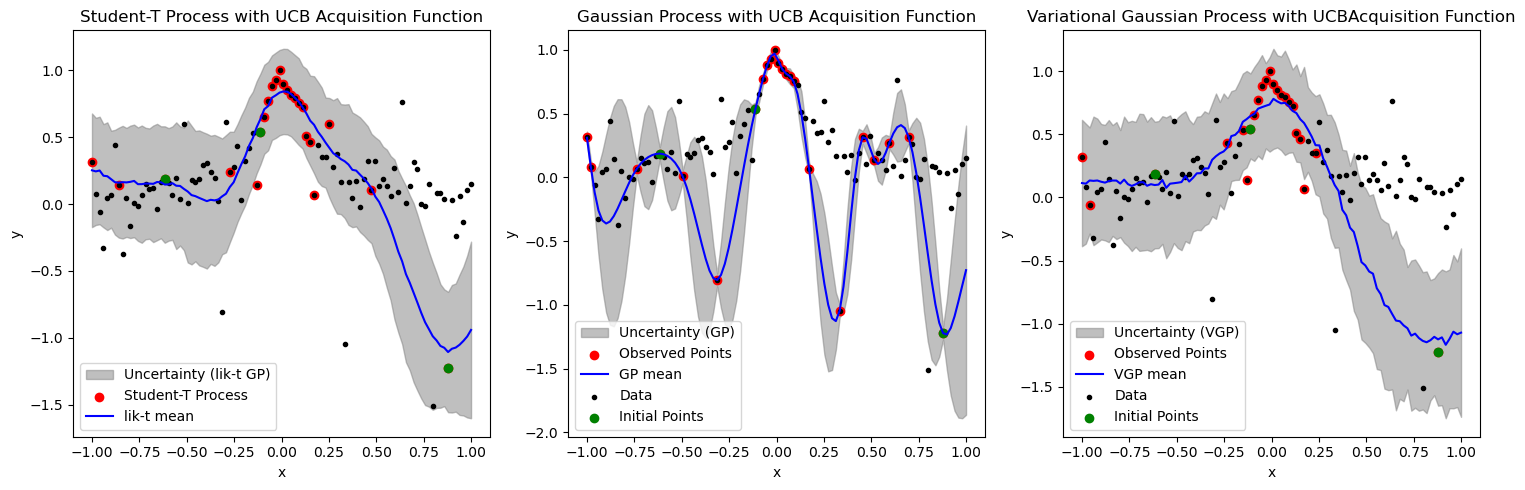

In [12]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))  # Adjusted figsize for better visibility

# First subplot
ax1.fill_between(train_x.numpy(), (meanSTP - 2*stdSTP).numpy(), (meanSTP + 2*stdSTP).numpy(), color='grey', alpha=0.5, label='Uncertainty (lik-t GP)')
ax1.scatter(train_xSTP.numpy(), train_ySTP.numpy(), c='red', label="Student-T Process")
ax1.plot(train_x.numpy(), meanSTP.numpy(), 'b-', label="lik-t mean")
ax1.legend(loc="best")
ax1.set(xlabel="x", ylabel="y", title="Student-T Process with "+ acqFunc + " Acquisition Function")
ax1.scatter(train_x.numpy(), train_y.numpy(), c='k', marker='.', label="Data")
ax1.scatter(initialPoints, initialPointsy, c='green', marker='o', label="Initial Points")

# Second subplot
ax2.fill_between(train_x.numpy(), (meanEGP - 2*stdEGP).numpy(), (meanEGP + 2*stdEGP).numpy(), color='grey', alpha=0.5, label='Uncertainty (GP)')
ax2.scatter(train_xEGP.numpy(), train_yEGP.numpy(), c='red', label="Observed Points")
ax2.plot(train_x.numpy(), meanEGP.numpy(), 'b-', label="GP mean")
ax2.scatter(train_x.numpy(), train_y.numpy(), c='k', marker='.', label="Data")
ax2.scatter(initialPoints, initialPointsy, c='green', marker='o', label="Initial Points")
ax2.legend(loc="best")
ax2.set(xlabel="x", ylabel="y", title="Gaussian Process with "+ acqFunc + " Acquisition Function")

# Third subplot
ax3.fill_between(train_x.numpy(), (meanVGP - 2*stdVGP).numpy(), (meanVGP + 2*stdVGP).numpy(), color='grey', alpha=0.5, label='Uncertainty (VGP)')
ax3.scatter(train_xVGP.numpy(), train_yVGP.numpy(), c='red', label="Observed Points")
ax3.plot(train_x.numpy(), meanVGP.numpy(), 'b-', label="VGP mean")
ax3.scatter(train_x.numpy(), train_y.numpy(), c='k', marker='.', label="Data")
ax3.scatter(initialPoints, initialPointsy, c='green', marker='o', label="Initial Points")
ax3.legend(loc="best")
ax3.set(xlabel="x", ylabel="y", title="Variational Gaussian Process with " + acqFunc + "Acquisition Function")

# Adjust layout
plt.tight_layout()
plt.show()